In [764]:
# Pipelines imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [765]:
# importit bibliotheque
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

data_path = os.path.join(os.path.curdir, 'data')
print(os.getcwd())
# loadit les csv
general_data_brute = pd.read_csv(os.path.join(data_path, 'general_data.csv'))
in_time_brute = pd.read_csv(os.path.join(data_path, 'in_time.csv'))
out_time_brute = pd.read_csv(os.path.join(data_path, 'out_time.csv'))
manager_survey_data_brute = pd.read_csv(
    os.path.join(data_path, 'manager_survey_data.csv'))
employee_survey_data_brute = pd.read_csv(
    os.path.join(data_path, 'employee_survey_data.csv'))


c:\Users\Nazim\Documents\Dev\HumanForYou


In [766]:
pd.set_option('display.max_columns', None)


In [767]:
general_data_brute.head()  # affichit head tae csv


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [768]:
general_data_brute.describe()  # descriptit general data


,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


In [769]:
general_data_brute.info()  # affichit les infos ta3 chaque collone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

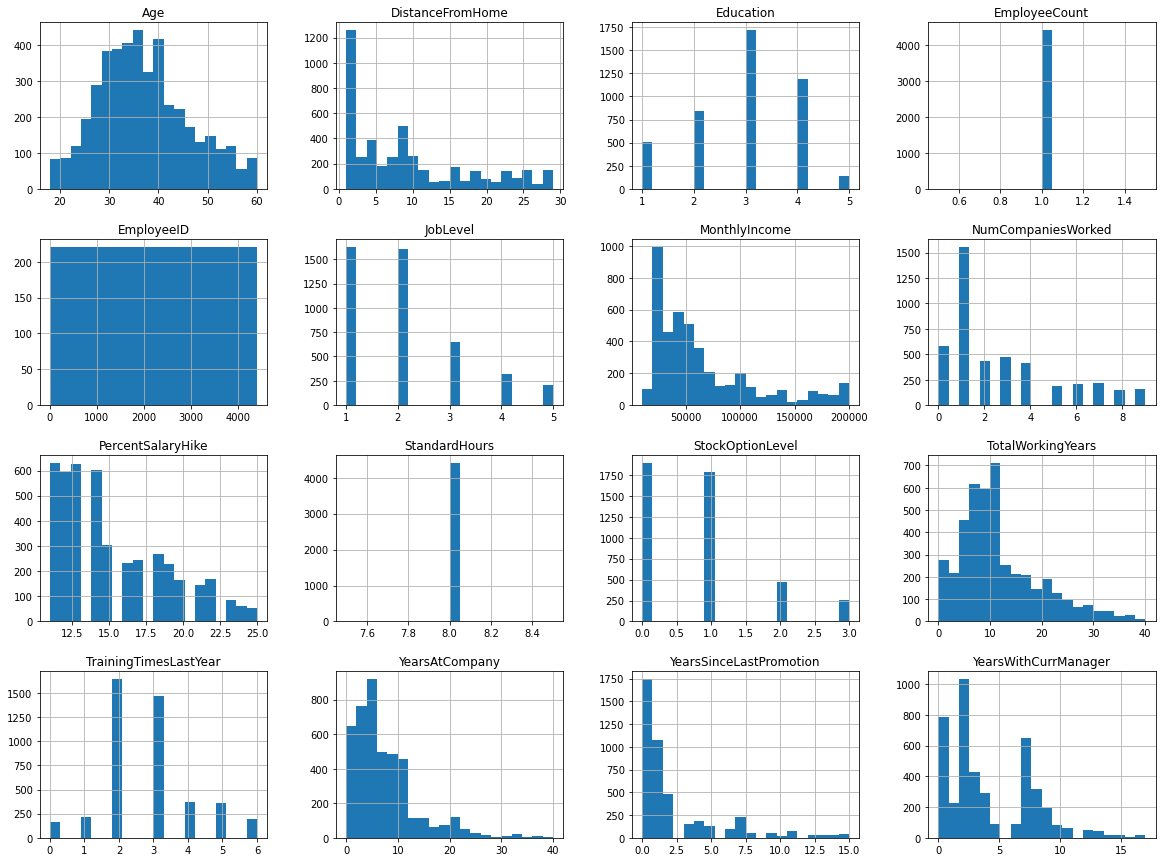

In [770]:
general_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()

# affichit histogramme tae dataset general


In [771]:
manager_survey_data_brute.head()


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [772]:
manager_survey_data_brute.describe()


,EmployeeID,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000
mean,2205.500000,2.729932,3.153741
std,1273.201673,0.711400,0.360742
min,1.000000,1.000000,3.000000
25%,1103.250000,2.000000,3.000000
50%,2205.500000,3.000000,3.000000
75%,3307.750000,3.000000,3.000000
max,4410.000000,4.000000,4.000000


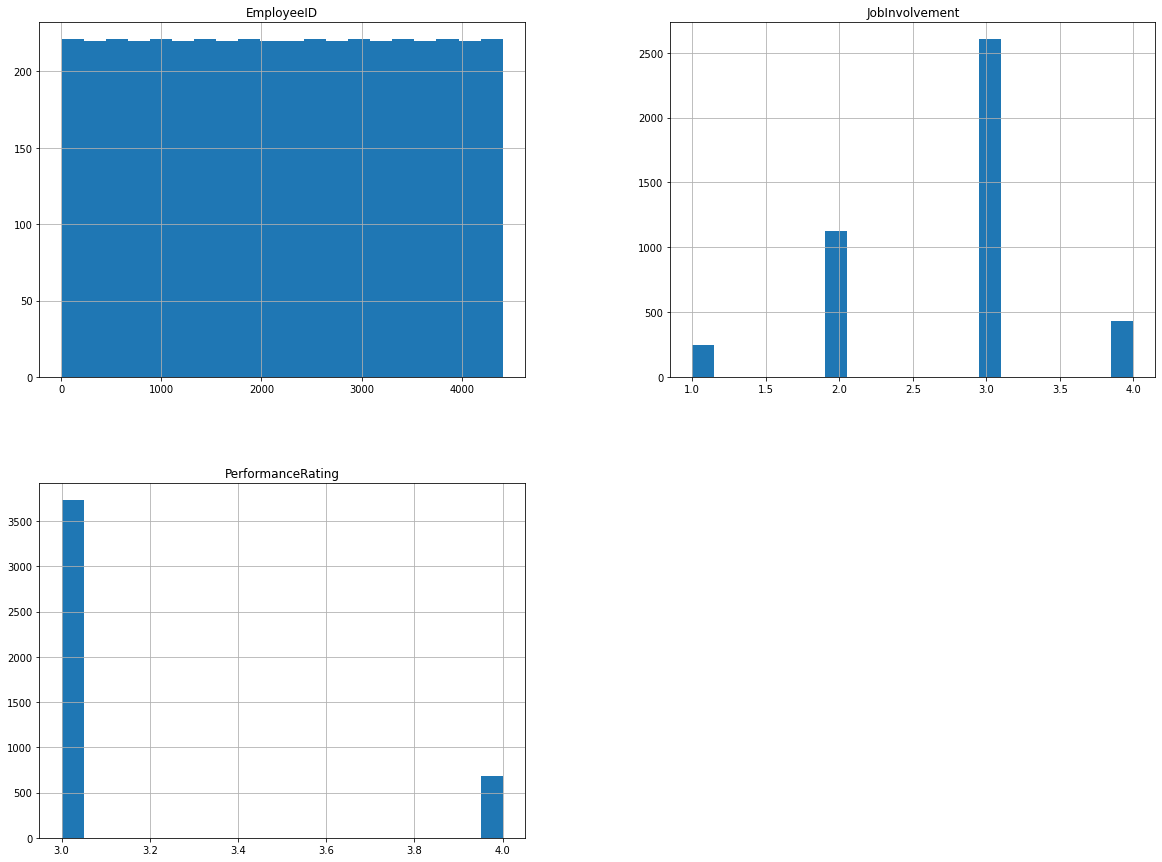

In [773]:
manager_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()


In [774]:
employee_survey_data_brute.head()


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [775]:
employee_survey_data_brute.describe()


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4385.000000,4390.000000,4372.000000
mean,2205.500000,2.723603,2.728246,2.761436
std,1273.201673,1.092756,1.101253,0.706245
min,1.000000,1.000000,1.000000,1.000000
25%,1103.250000,2.000000,2.000000,2.000000
50%,2205.500000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000


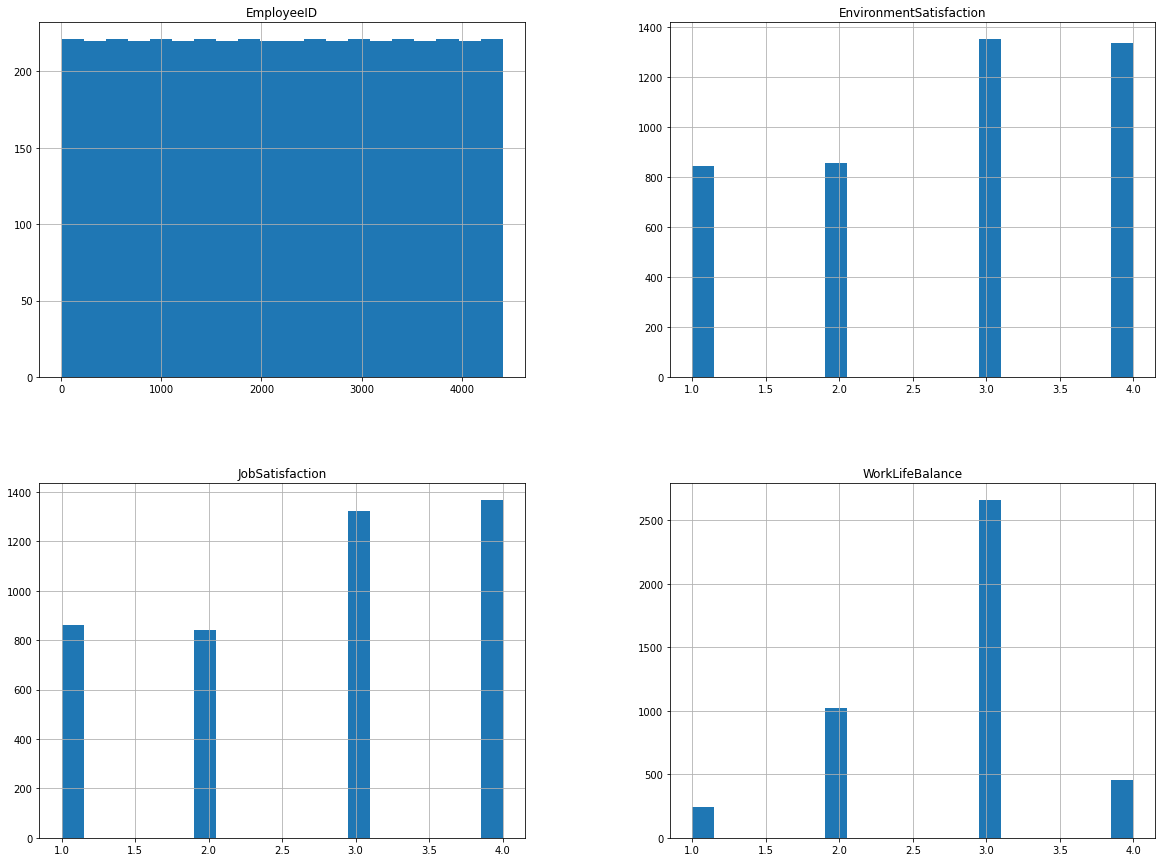

In [776]:
employee_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()


collone a ajouter :
abscences
heures supp


In [777]:
general_data = general_data_brute.drop('Over18', axis=1)
general_data = general_data.drop('StandardHours', axis=1)
general_data = general_data.drop('EmployeeCount', axis=1)


# deletit zoudj les collone


In [778]:
general_data.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4


In [779]:
in_time_brute.head()


,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,2015-01-15 10:01:24,2015-01-16 10:19:08,NaN,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,NaN,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,NaN,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,NaN,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,NaN,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,NaN,2015-03-27 09:47:30,2

In [780]:
out_time = out_time_brute.copy()
out_time['employee_id'] = out_time[out_time.columns[0]]
out_time = out_time.drop(out_time.columns[0], axis=1)
# segemt la collone li ma 3ndhach asem


In [781]:
in_time = in_time_brute.copy()
in_time['employee_id'] = in_time[in_time.columns[0]]
in_time = in_time.drop(in_time.columns[0], axis=1)

# segemt la collone li ma 3ndhach asem


In [782]:
free_days = []
for col in in_time.columns:
    if in_time[col].isna().all():
        in_time = in_time.drop(col, axis=1)
        out_time = out_time.drop(col, axis=1)

# nehit les jours ferié


In [783]:
out_time.head()


,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31,employee_id
0,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,2015-01-15 17:22:13,2015-01-16 17:35:11,NaN,2015-01-20 16:37:07,2015-01-21 16:55:24,2015-01-22 16:50:47,2015-01-23 17:00:01,2015-01-27 17:28:22,2015-01-28 17:03:21,2015-01-29 17:18:36,2015-01-30 17:00:25,2015-02-02 16:32:49,2015-02-03 17:35:49,2015-02-04 17:24:56,2015-02-05 17:26:31,2015-02-06 17:21:35,2015-02-09 17:37:50,2015-02-10 17:30:20,2015-02-11 17:30:19,2015-02-12 17:36:42,2015-02-13 16:25:26,2015-02-16 17:50:23,2015-02-17 17:28:06,2015-02-18 18:13:29,NaN,2015-02-20 17:44:52,2015-02-23 17:13:27,2015-02-24 17:24:48,2015-02-25 17:27:37,2015-02-26 17:08:36,2015-02-27 17:21:55,2015-03-02 17:29:08,2015-03-03 16:54:12,2015-03-04 17:50:18,2015-03-06 17:44:47,2015-03-09 17:53:05,2015-03-10 16:42:53,2015-03-11 16:58:39,2015-03-12 17:15:39,2015-03-13 17:25:55,NaN,2015-03-17 17:00:16,2015-03-18 17:40:13,2015-03-19 17:52:44,2015-03-20 17:47:34,2015-03-23 17:48:18,2015-03-24 17:48:26,2015-03-25 17:08:19,NaN,2015-03-27 17:20:51,2015-03-30 17:33:09,2015-03-31 18:00:07,2015-04-01 17:32:50,2015-04-02 17:24:58,2015-04-03 17:11:46,2015-04-06 16:42:46,2015-04-07 17:55:07,2015-04-08

In [784]:
# count work hours for each employee
from datetime import datetime, timedelta
employees_hours = []
additional_hours = []
minus_hours = []
abscences = []
for index, row in general_data.iterrows():
    employee_id = row['EmployeeID']
    in_time_employee = in_time[in_time['employee_id']
                               == employee_id].values[0]
    out_time_employee = out_time[out_time['employee_id']
                                 == employee_id].values[0]
    out_time_employee = out_time_employee[:-1]
    in_time_employee = in_time_employee[:-1]
    abscence = np.count_nonzero(in_time_employee == 'NaN')
    abscences.append(abscence)
    now = datetime.now()
    in_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in in_time_employee])
    out_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in out_time_employee])

    employee_hours = out_time_employee - in_time_employee
    employee_hours = [x.total_seconds() for x in employee_hours]
    employee_hours = sum(employee_hours)
    employees_hours.append(employee_hours/(60**2))
    nb_day = len(out_time_employee)
    additional_hour = ((8*(nb_day))-employee_hours/(60**2))
    if additional_hour < 0:
        additional_hour = 0
        minus_hour = -1 * additional_hour
    else:
        minus_hour = 0

    additional_hours.append(additional_hour)
    minus_hours.append(minus_hour)
general_data['worked_hour'] = employees_hours
general_data['additional_hour'] = additional_hours


In [785]:
np.count_nonzero(abscences)


0

In [786]:
general_data['worked_hour']


0       1710.686944
1       1821.676667
2       1697.204167
3       1690.514444
4       1961.512778
           ...     
4405    2070.913333
4406    1468.401944
4407    1780.231944
4408    2287.715278
4409    1621.435833
Name: worked_hour, Length: 4410, dtype: float64

In [787]:
general_data.describe()


,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,worked_hour,additional_hour
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,2205.500000,2.063946,65029.312925,2.694830,15.209524,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,1821.276283,250.742404
std,9.133301,8.105026,1.023933,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,331.361528,201.088676
min,18.000000,1.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1348.803056,0.000000
25%,30.000000,2.000000,2.000000,1103.250000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,1563.572500,24.704653
50%,36.000000,7.000000,3.000000,2205.500000,2.000000,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,1745.782222,246.217778
75%,43.000000,14.000000,4.000000,3307.750000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,1967.295347,428.427500
max,60.000000,29.000000,5.000000,4410.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,2723.378056,643.196944


In [788]:
general_data = pd.merge(
    general_data, employee_survey_data_brute, on="EmployeeID", how='left')
general_data

# dert join bin general_data w survey_employee


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,worked_hour,additional_hour,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,1710.686944,281.313056,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,1821.676667,170.323333,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,1697.204167,294.795833,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,1690.514444,301.485556,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,1961.512778,30.487222,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,Single,60290,3.0,17,1,10.0,5,3,0,2,2070.913333,0.000000,4.0,1.0,3.0
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,Divorced,26790,2.0,15,0,10.0,2,3,0,2,1468.401944,523.598056,4.0,4.0,3.0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,Married,37020,0.0,20,0,5.0,4,4,1,2,1780.231944,211.768056,1.0,3.0,3.0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,Divorced,23980,0.0,14,1,10.0,2,9,7,8,2287.715278,0.000000,4.0,1.0,3.0


In [789]:
general_data = pd.merge(
    general_data, manager_survey_data_brute, on="EmployeeID", how="left")
general_data['WorkLifeBalance']
# dert join bin general_data w manager_employee


0       2.0
1       4.0
2       1.0
3       3.0
4       3.0
       ... 
4405    3.0
4406    3.0
4407    3.0
4408    3.0
4409    NaN
Name: WorkLifeBalance, Length: 4410, dtype: float64

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'Education'}>,
        <AxesSubplot:title={'center':'EmployeeID'}>,
        <AxesSubplot:title={'center':'JobLevel'}>],
       [<AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'StockOptionLevel'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>],
       [<AxesSubplot:title={'center':'TrainingTimesLastYear'}>,
        <AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>,
        <AxesSubplot:title={'center':'YearsWithCurrManager'}>,
        <AxesSubplot:title={'center':'worked_hour'}>],
       [<AxesSubplot:title={'center':'additional_hour'}>,
        <AxesSubplot:title={'center':'EnvironmentSatisfaction'}>,
        <Axe

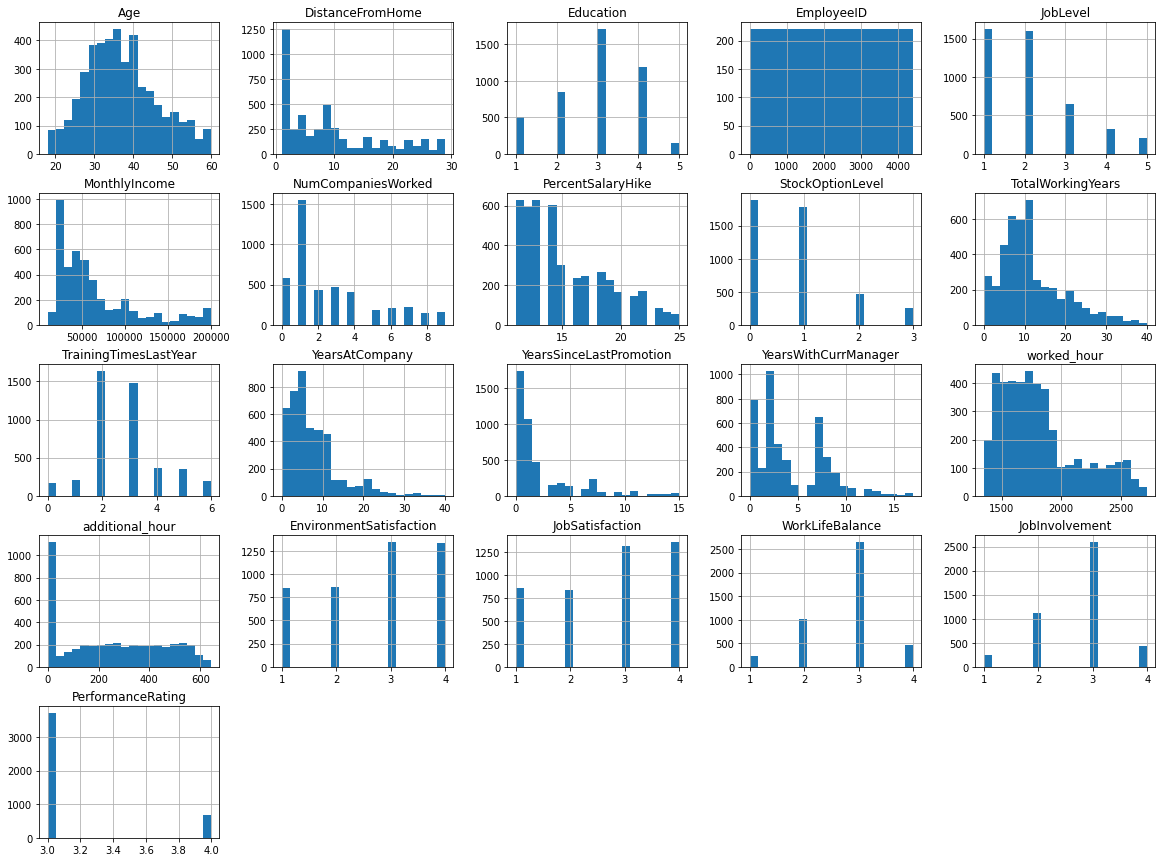

In [790]:
general_data.hist(bins=20, figsize=(20, 15))


In [791]:
ordinal_columns = [
    'Attrition',
    'Gender',
]
onehot_columns = [
    'Department',
    'EducationField',
    'JobRole',
    'MaritalStatus',
]

one_hot_cat = []

for col in onehot_columns:
    one_hot_cat.append(general_data[col].unique())


bussiness_travel_values = ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']
fill_only_col = [
    "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", 'NumCompaniesWorked']

numeric_cols = [
    'TotalWorkingYears',
    'worked_hour',
    'additional_hour',
    'DistanceFromHome',
    'MonthlyIncome',
    'PercentSalaryHike',
    'StockOptionLevel',
    'TrainingTimesLastYear',
    'YearsAtCompany',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager',
]


In [792]:
one_hot_cat

[array(['Sales', 'Research & Development', 'Human Resources'], dtype=object),
 array(['Life Sciences', 'Other', 'Medical', 'Marketing',
        'Technical Degree', 'Human Resources'], dtype=object),
 array(['Healthcare Representative', 'Research Scientist',
        'Sales Executive', 'Human Resources', 'Research Director',
        'Laboratory Technician', 'Manufacturing Director',
        'Sales Representative', 'Manager'], dtype=object),
 array(['Married', 'Single', 'Divorced'], dtype=object)]

In [793]:
general_data['WorkLifeBalance'] = general_data['WorkLifeBalance'].astype(float)
general_data['EnvironmentSatisfaction'] = general_data['EnvironmentSatisfaction'].astype(
    float)
general_data['JobSatisfaction'] = general_data['JobSatisfaction'].astype(float)
general_data['NumCompaniesWorked'] = general_data['NumCompaniesWorked'].astype(
    float)
general_data['TotalWorkingYears'] = general_data['TotalWorkingYears'].astype(
    float)


In [795]:
numeric_pipline = Pipeline([
    ('fill_na_num', SimpleImputer(strategy='median')),
    ('standardisation', StandardScaler()),
])
col_transformer = ColumnTransformer([
    ('fill_na', SimpleImputer(strategy='median'), fill_only_col),
    ('numeric', numeric_pipline, numeric_cols),
    ("qualitative", OneHotEncoder(categories=one_hot_cat), onehot_columns),
    ('bool', OrdinalEncoder(dtype=int), ordinal_columns),
    ("BusinessTravel", OrdinalEncoder(categories=[
     bussiness_travel_values]), ['BusinessTravel'])
])


In [796]:
pre_general_data = col_transformer.fit_transform(general_data)


In [797]:
copy_general_data = general_data.copy()


In [798]:
start = 0

In [799]:
for col in fill_only_col:
    general_data[col] = pre_general_data[:, start]
    start+=1

In [800]:
for col in numeric_cols:
    general_data[col] = pre_general_data[:, start]
    start+=1


In [801]:

for col in onehot_columns:
    for v in general_data[col].unique():
        general_data[v] = pre_general_data[:, start]
        general_data[v] = general_data[v].astype(int)
        start += 1
    general_data = general_data.drop(col, axis=1)


In [802]:
for col in ordinal_columns:
    general_data[col] = pre_general_data[:, start]
    general_data[col] = general_data[col].astype(int)
    start += 1

In [803]:
general_data['BusinessTravel'] = pre_general_data[:, start]
general_data['BusinessTravel'] = general_data['BusinessTravel'].astype(int)


In [804]:
general_data.tail(5)

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,worked_hour,additional_hour,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Sales,Research & Development,Human Resources,Life Sciences,Other,Medical,Marketing,Technical Degree,Healthcare Representative,Research Scientist,Sales Executive,Research Director,Laboratory Technician,Manufacturing Director,Sales Representative,Manager,Married,Single,Divorced
4405,42,0,1,-0.517332,4,4406,0,1,-0.100700,3.0,0.489376,0.241988,-0.164315,1.707500,-0.654454,-0.679146,-0.595227,0.753453,-1.247066,4.0,1.0,3.0,3,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4406,29,0,1,-0.887515,4,4407,1,1,-0.812504,2.0,-0.057267,-0.932014,-0.164315,-0.620189,-0.654454,-0.679146,-0.595227,-1.065043,1.357046,4.0,4.0,3.0,2,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4407,25,0,1,1.950552,2,4408,1,2,-0.595138,0.0,1.309341,-0.932014,-0.807517,0.931603,-0.491174,-0.368715,-0.595227,-0.123880,-0.193839,1.0,3.0,3.0,3,4,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4408,42,0,1,1.086793,2,4409,1,1,-0.872210,0.0,-0.330589,0.241988,-0.164315,-0.620189,0.325228,1.493867,1.086895,1.407803,-1.247066,4.0,1.0,3.0,2,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4409,40,0,1,2.320735,3,4410,1,2,-0.219901,0.0,-0.877232,-0.932014,-0.164315,2.483396,2.284590,0.252146,1.367249,-0.603157,0.595933,1.0,3.0,3.0,4,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [805]:
corr_matrix = general_data.corr()
corr_matrix.style.background_gradient(cmap='Wistia')


,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,worked_hour,additional_hour,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Sales,Research & Development,Human Resources,Life Sciences,Other,Medical,Marketing,Technical Degree,Healthcare Representative,Research Scientist,Sales Executive,Research Director,Laboratory Technician,Manufacturing Director,Sales Representative,Manager,Married,Single,Divorced
Age,1.000000,-0.159205,-0.011807,0.006963,-0.035706,0.008649,-0.039352,-0.002884,-0.044314,0.298869,-0.033137,-0.031753,0.680340,-0.027308,0.311309,0.216513,0.202089,-0.000377,0.012520,0.009699,-0.003003,-0.020524,0.018196,-0.025563,-0.015558,0.018040,0.001194,-0.001790,-0.001543,0.009673,-0.032831,0.046655,-0.051511,0.005834,0.008219,-0.016059,0.033969,0.001261,-0.014096,0.009020,0.083919,-0.119185,0.033120
Attrition,-0.159205,1.000000,0.127006,-0.009730,-0.015111,-0.004729,0.018125,-0.010290,-0.031176,0.042064,0.032533,-0.006839,-0.170162,-0.049431,-0.134392,-0.033019,-0.156199,0.198890,-0.189422,-0.101625,-0.103068,-0.062975,-0.015588,0.023403,-0.019742,-0.015307,-0.013857,0.012394,-0.025958,0.000764,-0.003780,-0.040646,-0.013768,0.027460,0.010869,0.049760,0.001179,-0.045770,-0.011073,-0.017798,-0.090984,0.175419,-0.087716
BusinessTravel,-0.011807,0.127006,1.000000,0.014130,0.007567,-0.003737,-0.021404,0.013727,-0.055905,-0.030698,-0.025727,0.004770,0.008298,-0.043173,0.005212,0.005222,-0.000229,0.049254,-0.060034,-0.009892,0.008949,0.004914,0.025705,-0.019587,0.056932,-0.053821,0.003513,-0.039889,-0.000470,0.030025,0.054607,-0.028644,0.003062,0.008887,-0.022053,0.017409,-0.011332,0.036336,-0.028647,0.000945,0.002198,0.023017,-0.028444
DistanceFromHome,0.006963,-0.009730,0.014130,1.000000,-0.008638,-0.001097,-0.044173,-0.037329,-0.021607,-0.013514,0.038125,0.011169,0.009314,-0.009001,0.031684,0.002290,0.021584,0.009928,-0.014390,0.020113,-0.011213,0.008305,-0.001837,0.036418,0.003129,0.007409,0.001813,0.009607,-0.014552,-0.008728,0.005240,-0.010691,-0.016564,-0.002360,-0.012479,-0.003849,0.052249,0.000305,0.005463,-0.038859,0.038151,-0.042204,0.001624
Education,-0.035706,-0.015111,0.007567,-0.008638,1.000000,-0.009680,-0.016547,0.045746,0.006410,-0.016195,-0.040531,0.001261,-0.010813,0.010472,0.006080,0.022490,0.005358,0.001406,-0.006790,-0.045636,-0.004612,-0.005610,-0.018279,-0.035591,0.001207,-0.007431,0.045063,0.006435,0.046729,-0.020869,-0.008889,0.003472,-0.013044,0.000709,-0.004180,0.049694,-0.077518,-0.011976,0.032320,0.044142,-0.008534,0.024114,-0.016818
EmployeeID,0.008649,-0.004729,-0.003737,-0.001097,-0.009680,1.000000,-0.013165,-0.003303,0.007338,-0.000789,-0.004456,-0.014254,-0.000956,-0.010191,0.004086,0.000256,0.008579,-0.010239,0.004423,0.000455,-0.001024,-0.002164,0.008591,-0.006892,0.005417,-0.014299,-0.008991,-0.000302,0.003532,-0.002975,-0.004620,0.001983,0.002764,-0.004666,0.001284,-0.002202,-0.008073,0.013529,0.009162,-0.001464,0.000419,0.000823,-0.001424
Gender,-0.039352,0.018125,-0.021404,-0.044173,-0.016547,-0.013165,1.000000,-0.026854,0.007530,-0.067120,0.011841,0.019237,-0.027616,-0.030167,-0.017277,-0.021812,0.004438,0.003231,-0.003036,-0.023277,0.015923,-0.032373,0.025768,0.051586,0.007249,-0.010507,0.006014,0.006770,0.004840,-0.031072,0.002683,0.018457,-0.002924,0.030628,-0.005348,0.000000,0.013121,-0.004657,-0.010829,-0.044809,-0.035675,0.011910,0.029382
JobLevel,-0.002884,-0.010290,0.013727,-0.037329,0.045746,-0.003303,-0.026854,1.000000,0.047316,-0.010116,0.010973,0.000993,-0.036779,-0.032500,-0.064219,-0.060811,-0.055251,0.011067,0.009684,-0.024540,-0.018596,-0.027763,-0.012630,-0.002474,0.020701,-0.036763,0.028870,0.009053,-0.011367,-0.031310,0.035297,0.001202,0.007818,0.017455,-0.021969,0.032207,-0.031566,-0.004684,-0.024790,0.025348,0.007360,-0.021163,0

In [807]:
corr_matrix['Attrition']

Age                         -0.159205
Attrition                    1.000000
BusinessTravel               0.127006
DistanceFromHome            -0.009730
Education                   -0.015111
EmployeeID                  -0.004729
Gender                       0.018125
JobLevel                    -0.010290
MonthlyIncome               -0.031176
NumCompaniesWorked           0.042064
PercentSalaryHike            0.032533
StockOptionLevel            -0.006839
TotalWorkingYears           -0.170162
TrainingTimesLastYear       -0.049431
YearsAtCompany              -0.134392
YearsSinceLastPromotion     -0.033019
YearsWithCurrManager        -0.156199
worked_hour                  0.198890
additional_hour             -0.189422
EnvironmentSatisfaction     -0.101625
JobSatisfaction             -0.103068
WorkLifeBalance             -0.062975
JobInvolvement              -0.015588
PerformanceRating            0.023403
Sales                       -0.019742
Research & Development      -0.015307
Human Resour

In [806]:
general_data = general_data.drop("EmployeeID",axis=1)

In [808]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(general_data, general_data["Attrition"]):
    strat_train_set = general_data.loc[train_index]
    strat_test_set = general_data.loc[test_index]


In [809]:
y_train = strat_train_set['Attrition']
x_train = strat_train_set.drop('Attrition',axis=1)

In [810]:
x_train.isna().sum()

Age                          0
BusinessTravel               0
DistanceFromHome             0
Education                    0
Gender                       0
JobLevel                     0
MonthlyIncome                0
NumCompaniesWorked           0
PercentSalaryHike            0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
YearsAtCompany               0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
worked_hour                  0
additional_hour              0
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
JobInvolvement               0
PerformanceRating            0
Sales                        0
Research & Development       0
Human Resources              0
Life Sciences                0
Other                        0
Medical                      0
Marketing                    0
Technical Degree             0
Healthcare Representative    0
Research Scientist           0
Sales Ex

In [869]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10, random_state=42)
sgd_clf.fit(x_train, y_train)


c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=10, random_state=42)

In [870]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=5, scoring="accuracy")


c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

array([0.84419263, 0.83852691, 0.8470255 , 0.84680851, 0.84680851])

In [871]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=5)


c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

In [872]:
y_train.value_counts()

0    2959
1     569
Name: Attrition, dtype: int64

In [873]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)


array([[2954,    5],
       [ 543,   26]], dtype=int64)

In [874]:
from sklearn.metrics import precision_score, recall_score, f1_score


print("precision : " + str(precision_score(y_train, y_train_pred))[2:4] + "%")
print("recall : " + str(recall_score(y_train, y_train_pred))[2:4] + "%")
print('F1 : ' + str(f1_score(y_train, y_train_pred))[2:4] + "%")


precision : 83%
recall : 04%
F1 : 08%


c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Nazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

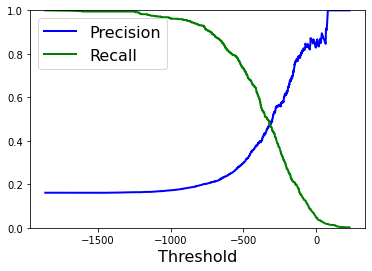

In [875]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(
    sgd_clf, x_train, y_train, cv=5, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.ylim([0, 1])
plt.show()